**TODO :**
- Augmentations
- LAB normalization ?

In [1]:
# %load_ext nb_black
%load_ext autoreload
%autoreload 2

## Initialization

### Imports

In [2]:
import os
import sys
import torch
import zipfile
import numpy as np
import pandas as pd
import plotly.express as px

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader

sys.path.append("../code/")

In [3]:
from params import *

from data.transforms import HE_preprocess
from data.dataset import TileDataset

from model_zoo.models import define_model

from training.main import k_fold
from utils.logger import (
    prepare_log_folder,
    save_config,
    create_logger,
    update_overall_logs,
)

from utils.plots import plot_contours

### Load

In [4]:
df_info = pd.read_csv(DATA_PATH + f"HuBMAP-20-dataset_information.csv")
df_mask = pd.read_csv(DATA_PATH + "train.csv")
df = pd.read_csv(OUT_PATH + "df_images.csv")

## Data

In [5]:
viz_ds = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=True),
)

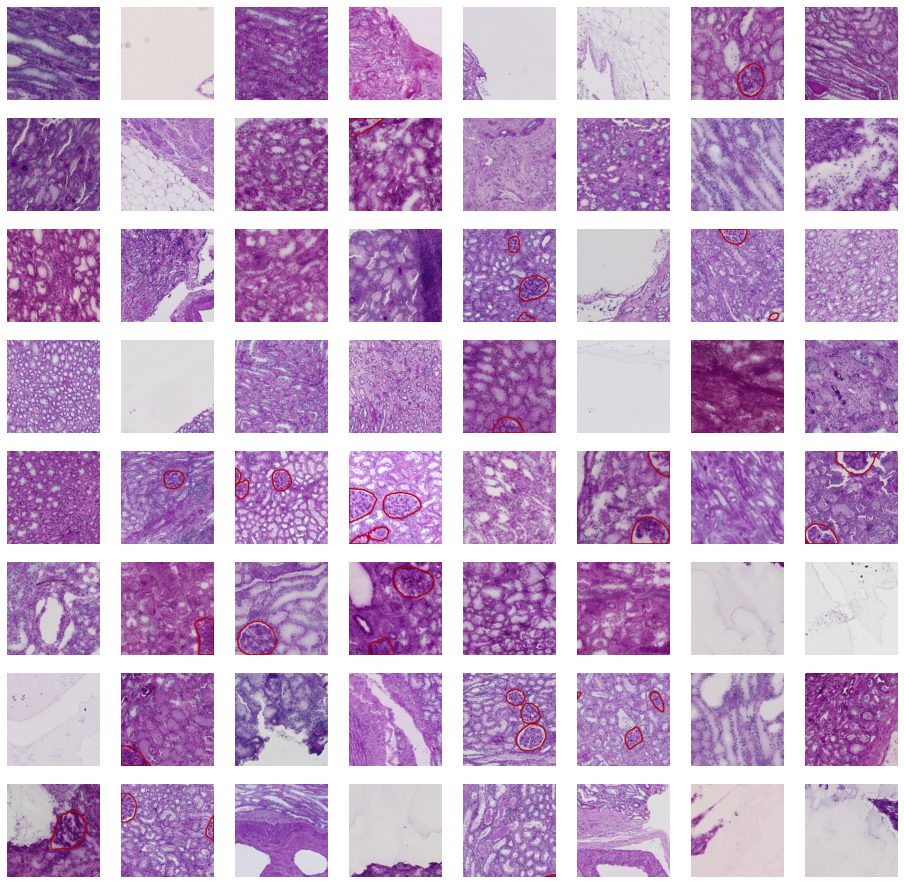

In [6]:
viz_dl = DataLoader(viz_ds, batch_size=64, shuffle=True)
imgs, masks = next(iter(viz_dl))

plt.figure(figsize=(16, 16))
for i, (img, mask) in enumerate(zip(imgs, masks)):
    img = img.permute(1, 2, 0).numpy()  # .astype(np.uint8)
    plt.subplot(8, 8, i + 1)
    
    plot_contours(img.copy(), mask.numpy(), w=2)
    plt.axis("off")
    plt.subplots_adjust(wspace=None, hspace=None)

## Model

In [7]:
from training.lovasz import *

In [8]:
dataset = TileDataset(
    df,
    IMG_PATH,
    MASK_PATH,
    transforms=HE_preprocess(augment=True, visualize=False),
)

In [9]:
model = define_model("Unet", "resnet18")

In [10]:
img, y = dataset[0]

In [11]:
pred = model(img.unsqueeze(0))

In [12]:
symmetric_lovasz(pred, y.unsqueeze(0))

tensor([9.8701], grad_fn=<DivBackward0>)

## Training

In [13]:
BATCH_SIZES = {
    "resnet34": 32, 
    "resnext50_32x4d": 32, 
    "se_resnext50_32x4d": 32,
    "efficientnet-b4": 32,
    "efficientnet-b5": 16,
    "efficientnet-b6": 8,
}

In [14]:
class Config:
    """
    Parameters used for training
    """
    # General
    seed = 42
    verbose = 1
    img_dir = IMG_PATH
    mask_dir = MASK_PATH
    device = "cuda" if torch.cuda.is_available() else "cpu"
    save_weights = True

    # k-fold
    cv_column = "5fold"
    random_state = 0
    selected_folds = [0, 1, 2, 3] # [0] / [0, 1, 2, 3]

    # Model
    encoder = "efficientnet-b5" # "efficientnet-b6", "se_resnext50_32x4d"
    decoder = "Unet"  # "Unet", "DeepLabV3Plus"
    encoder_weights = "imagenet"
    num_classes = 1

    # Training
    loss = "BCEWithLogitsLoss"  # "SoftDiceLoss" / "BCEWithLogitsLoss"  / "lovasz"
    activation = "none" if loss == "lovasz" else "sigmoid"

    optimizer = "Adam"
    batch_size = BATCH_SIZES[encoder]
    
    if batch_size == 32:
        epochs = 40
    elif batch_size == 16:
        epochs = 30
    elif batch_size == 8:
        epochs = 20
    
    lr = 1e-3
    swa_first_epoch = 50

    warmup_prop = 0.05
    val_bs = batch_size * 2

    first_epoch_eval = 0

    # Inference
    overlap_factor = 2

Best models : 
- se_resnext50_32x4d : logs/2020-12-21/3
- b4 : logs/2020-12-22/9/
- b5 : logs/2020-12-22/10/
- b6 : logs/2020-12-23/2/

In [15]:
DEBUG = False
log_folder = None

In [ ]:
if not DEBUG:
    log_folder = prepare_log_folder(LOG_PATH)
    print(f"Logging results to {log_folder}")
    config_df = save_config(Config, log_folder + "config.json")
    df.to_csv(log_folder + "data.csv", index=False)
    create_logger(directory=log_folder, name="logs.txt")

metrics = k_fold(Config, df, log_folder=log_folder)

Logging results to ../logs/2021-03-18/0/

-------------   Fold 1 / 5  -------------

    -> 8371 training images
    -> 1831 validation images
    -> 31216001 trainable parameters

Epoch 01/30 	 lr=6.7e-04	 t=175s	loss=0.411	val_loss=0.053 	 dice=0.8496
